Dosya: car10.jpg
   -> Netlik Skoru: 143
   -> Kontrast Artışı: %71.32


C:\Users\Zehra\AppData\Local\Temp\ipykernel_28516\346366985.py:115: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(gray.ravel(), 256, [0, 256], color='gray')
C:\Users\Zehra\AppData\Local\Temp\ipykernel_28516\346366985.py:123: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(final_save.ravel(), 256, [0, 256], color='black')


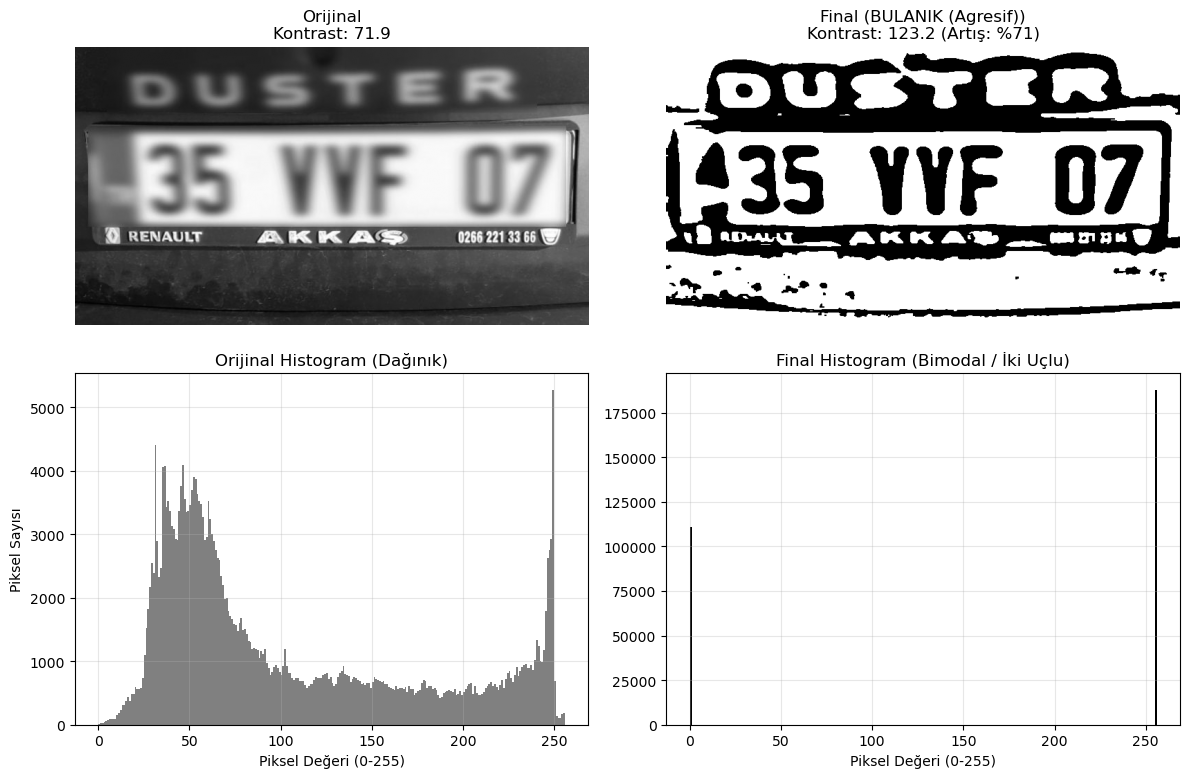

Dosya: car5.jpg
   -> Netlik Skoru: 383
   -> Kontrast Artışı: %99.77


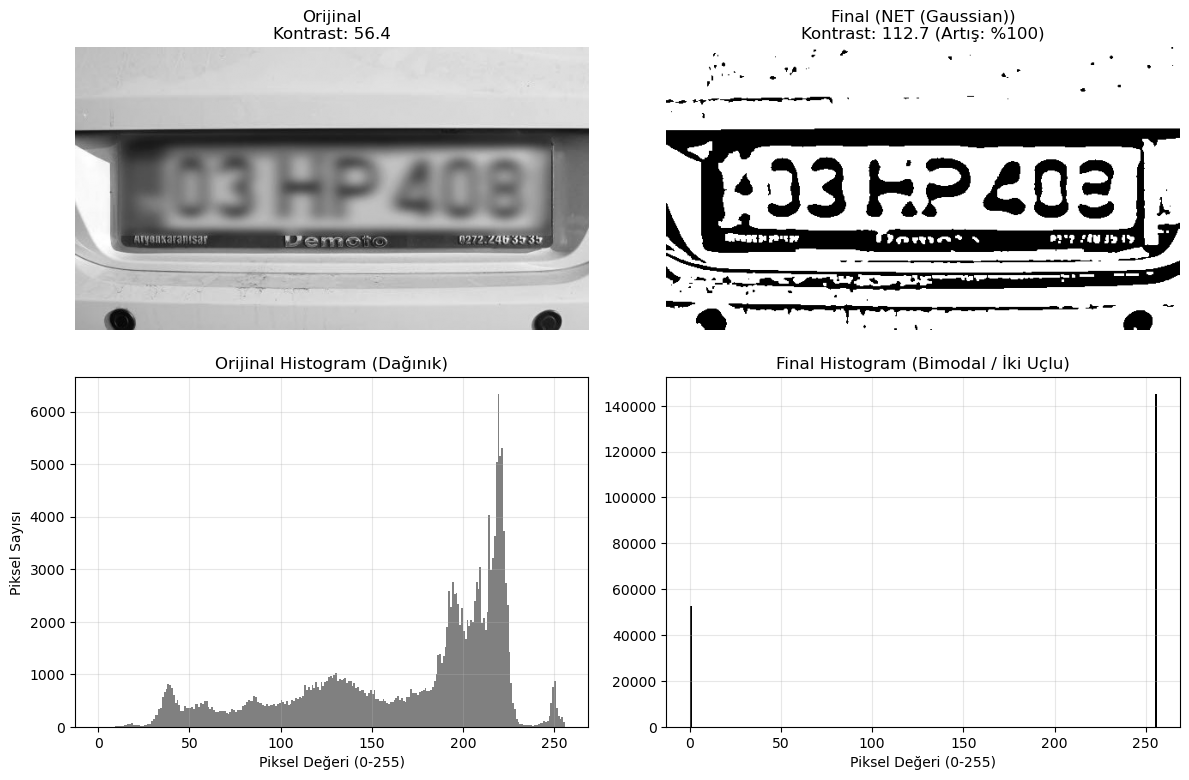

Dosya: car6.jpg
   -> Netlik Skoru: 42
   -> Kontrast Artışı: %136.43


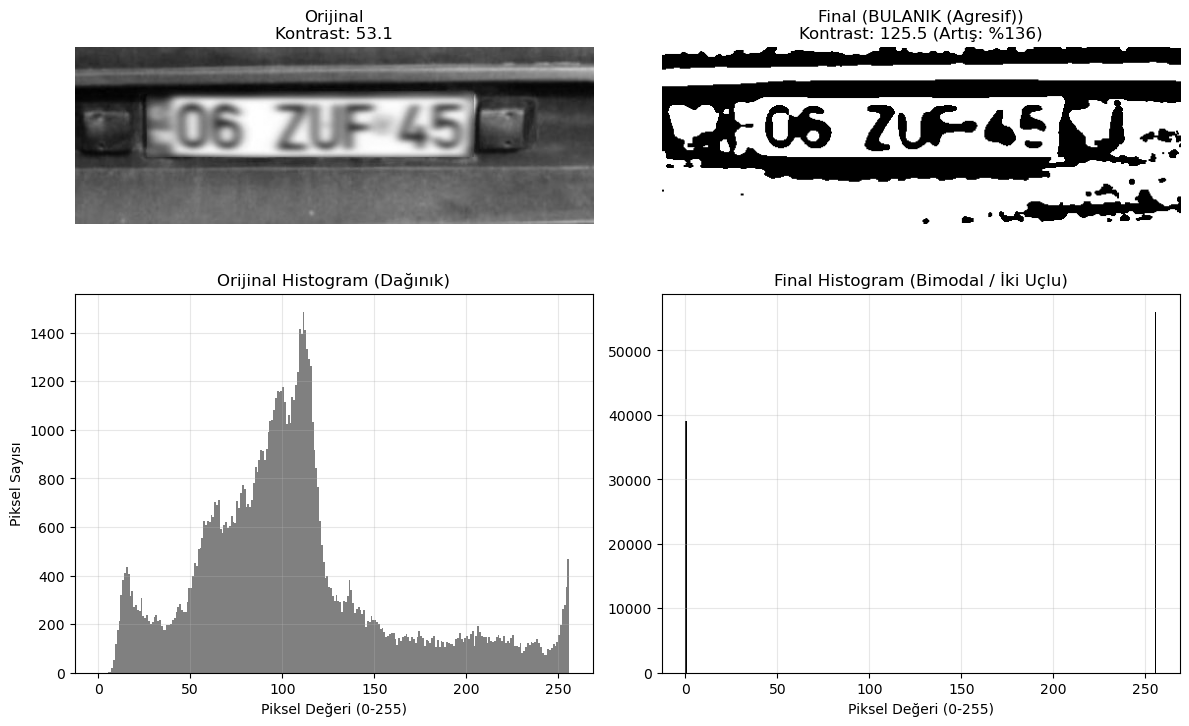

Dosya: car7.jpg
   -> Netlik Skoru: 253
   -> Kontrast Artışı: %90.28


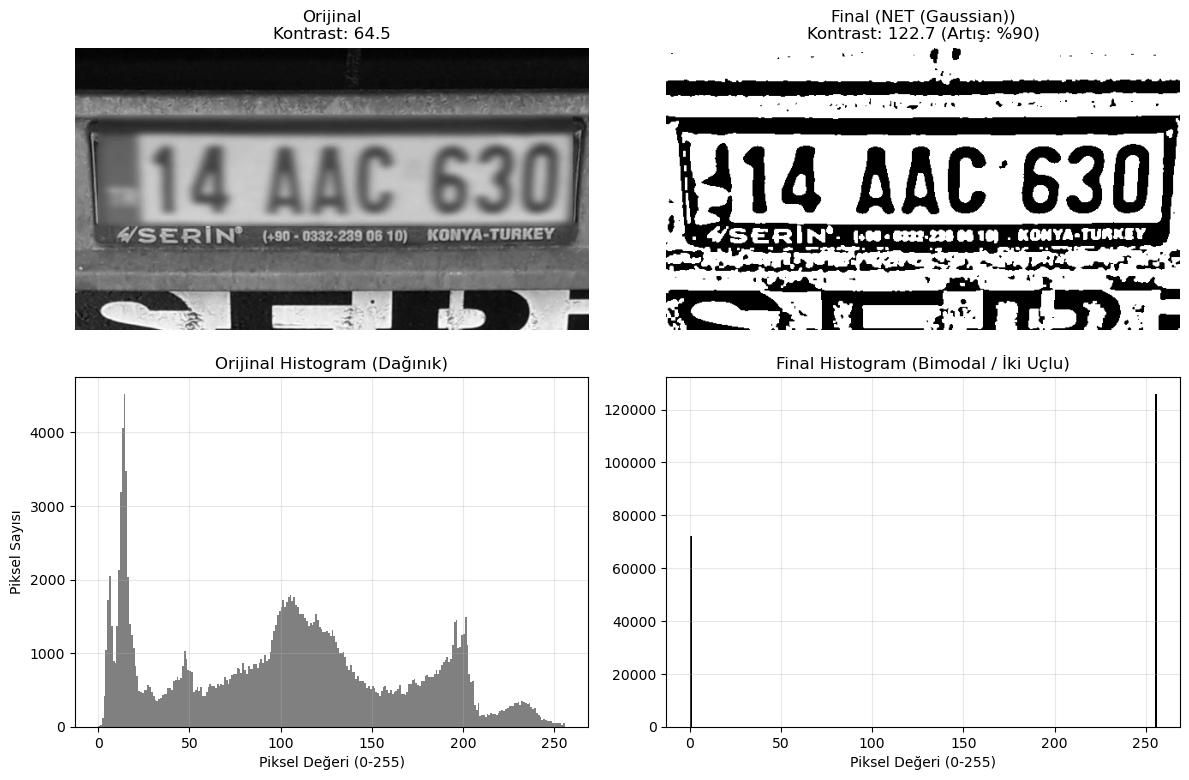

Dosya: car8.jpg
   -> Netlik Skoru: 119
   -> Kontrast Artışı: %176.17


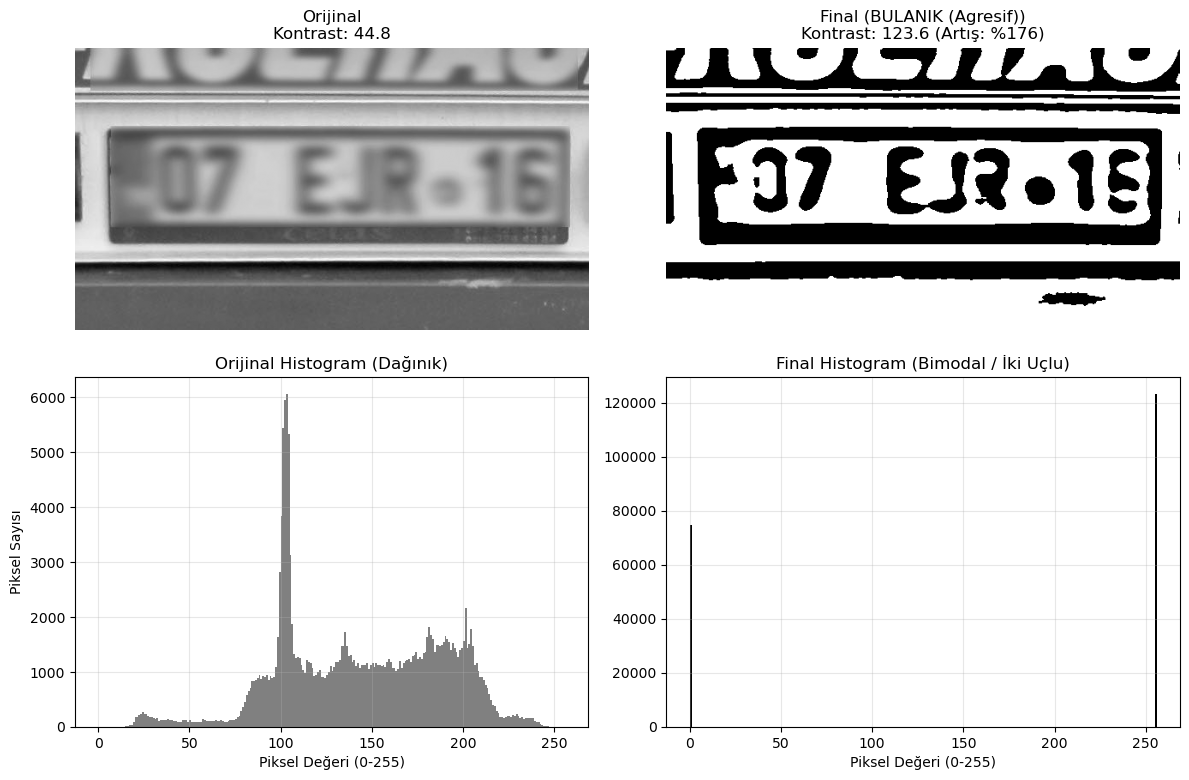

Dosya: WhatsApp Image 2025-12-19 at 5.30.26 PM.jpeg
   -> Netlik Skoru: 31
   -> Kontrast Artışı: %57.12


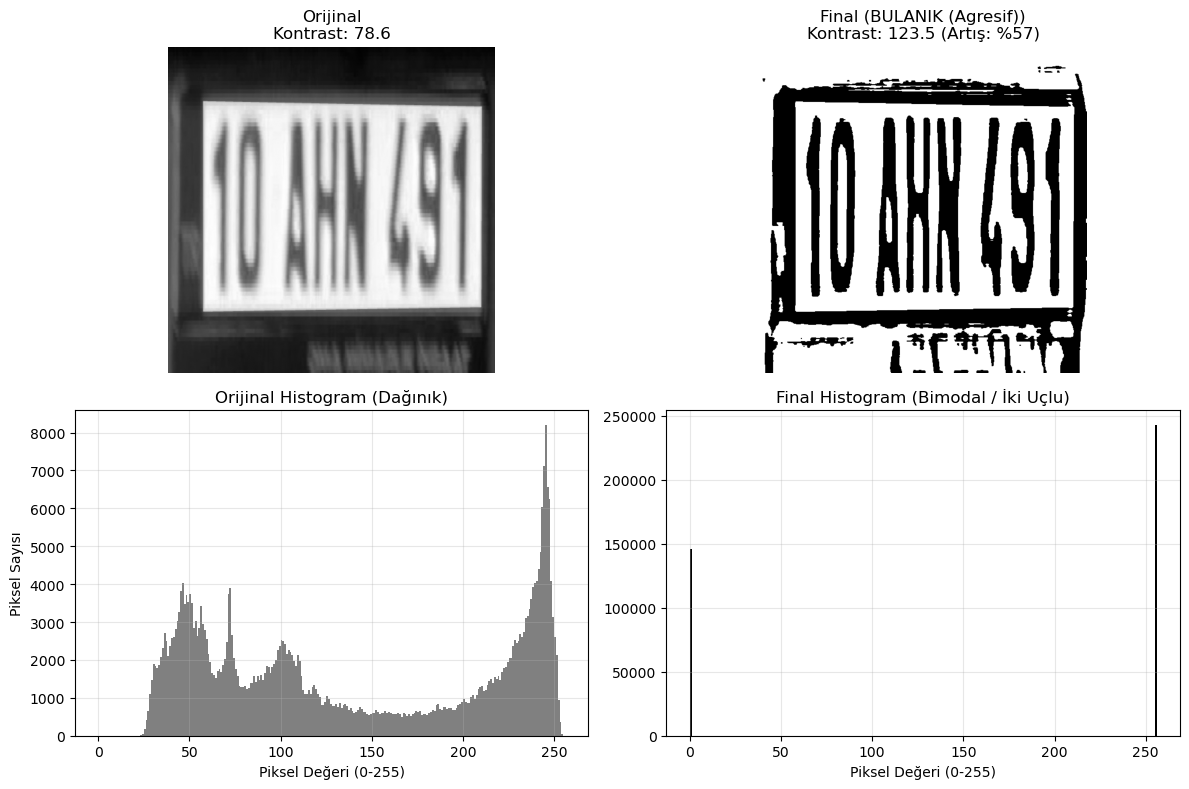

Dosya: WhatsApp Image 2025-12-19 at 5.30.27 PM.jpeg
   -> Netlik Skoru: 82
   -> Kontrast Artışı: %118.90


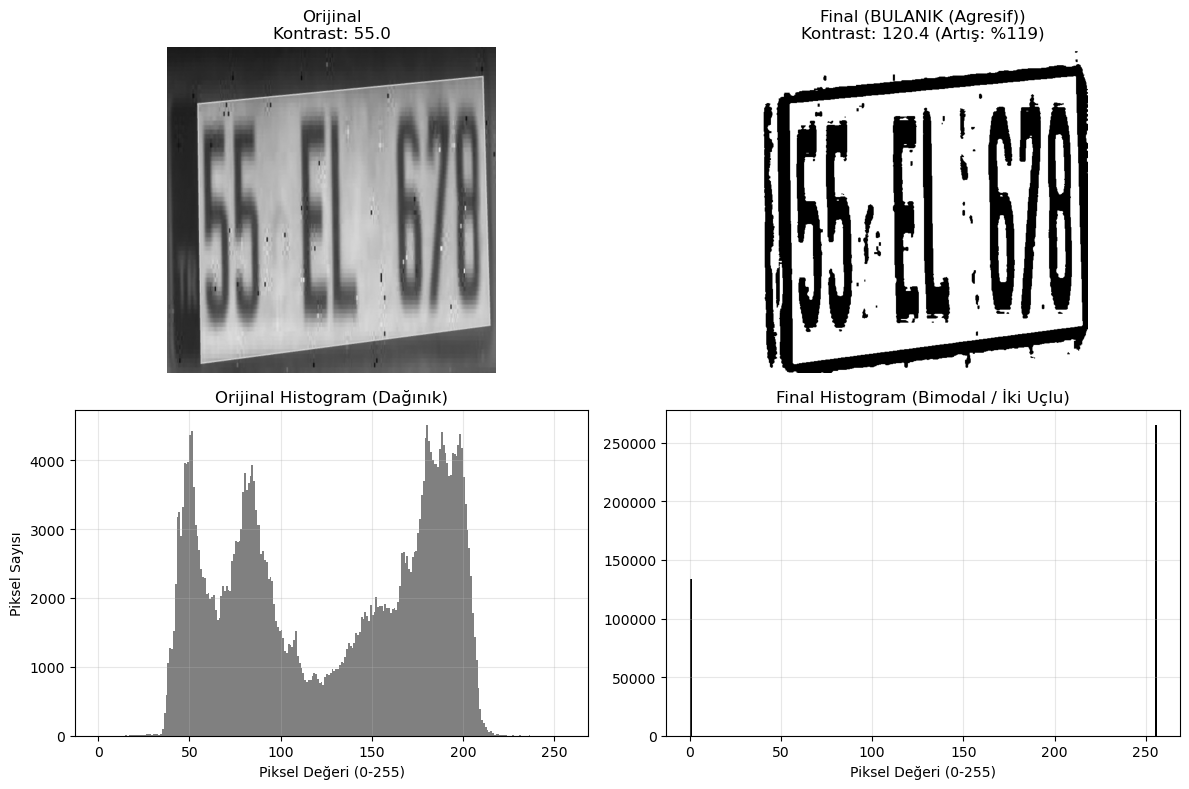

Dosya: WhatsApp Image 2025-12-19 at 5.30.27 PMd.jpeg
   -> Netlik Skoru: 249
   -> Kontrast Artışı: %243.35


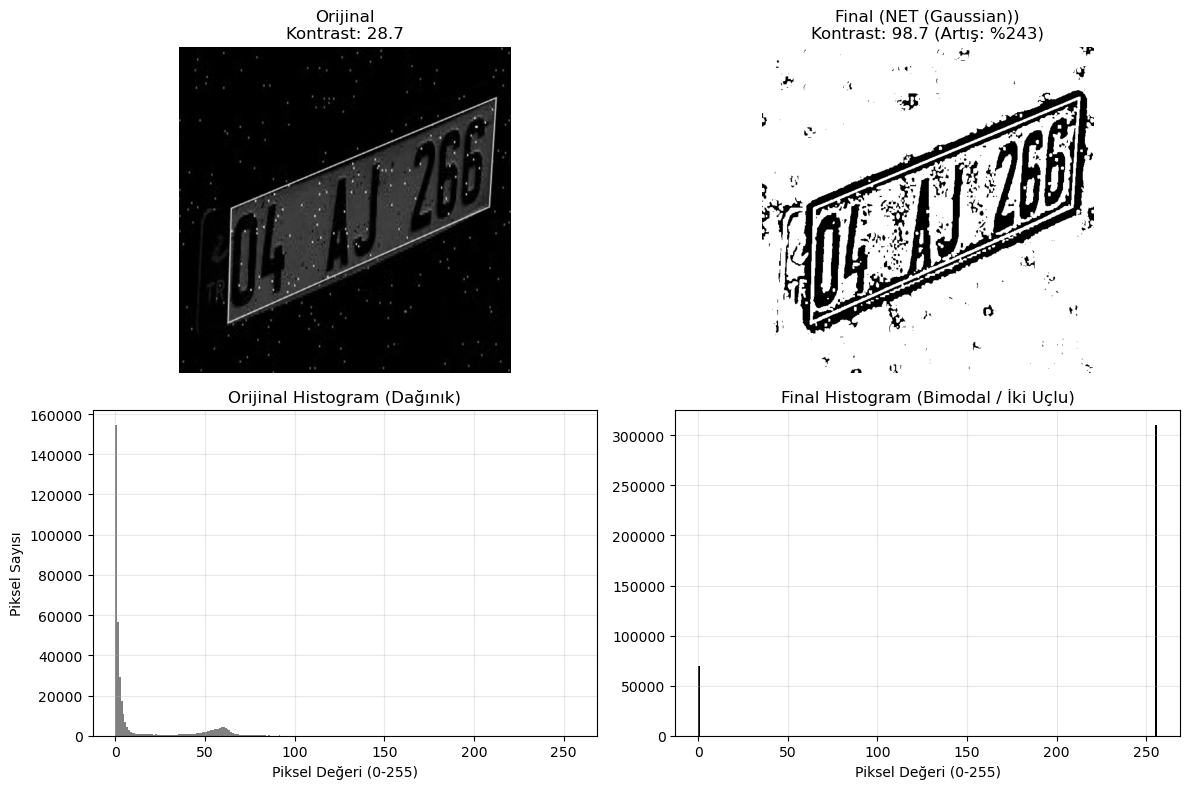

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# AYARLAR
# -------------------------------
images_folder = 'images'
output_folder = 'outputs/final_metric'
os.makedirs(output_folder, exist_ok=True)

# Çıktı penceresini biraz daha büyütelim (Histogram sığsın diye)
plt.rcParams['figure.figsize'] = (14, 8)

# -------------------------------
# METRİK FONKSİYONLARI (HOCA İÇİN)
# -------------------------------
def calculate_contrast(img):
    """
    RMS (Root Mean Square) Kontrast hesaplar.
    Bu değer, piksellerin gri ortalamasından ne kadar saptığını gösterir.
    Yüksek değer = Yüksek Kontrast = Daha iyi ayrışmış harfler.
    """
    return img.std()

def get_blur_score(img):
    # Laplacian Varyansı (Netlik Skoru)
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# -------------------------------
# İŞLEM FONKSİYONLARI (ESKİSİ GİBİ)
# -------------------------------
def process_sharp_image_optimized(gray):
    norm_img = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    blurred = cv2.GaussianBlur(norm_img, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 45, 4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    return cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

def process_blurry_image_aggressive(gray):
    norm_img = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    blurred = cv2.medianBlur(norm_img, 5)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY_INV, 51, 8)
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    connected = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_horizontal)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    return cv2.dilate(connected, kernel_dilate, iterations=1)

# -------------------------------
# ANA DÖNGÜ
# -------------------------------
files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

if not files:
    print("Resim bulunamadı!")
else:
    for img_file in files:
        img_path = os.path.join(images_folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 1. METRİK: Netlik Skoru
        blur_score = get_blur_score(gray)
        THRESHOLD_SCORE = 200 

        # İşlem Seçimi
        if blur_score > THRESHOLD_SCORE:
            status = "NET (Gaussian)"
            final = process_sharp_image_optimized(gray)
        else:
            status = "BULANIK (Agresif)"
            final = process_blurry_image_aggressive(gray)

        final_save = cv2.bitwise_not(final) # Siyah harf, beyaz zemin
        
        # 2. METRİK: Kontrast İyileştirme Oranı Hesaplama
        contrast_before = calculate_contrast(gray)
        contrast_after = calculate_contrast(final_save)
        
        # Yüzde kaç iyileşti?
        improvement_rate = ((contrast_after - contrast_before) / contrast_before) * 100

        print(f"Dosya: {img_file}")
        print(f"   -> Netlik Skoru: {int(blur_score)}")
        print(f"   -> Kontrast Artışı: %{improvement_rate:.2f}")

        # -------------------------------
        # GÖRSELLEŞTİRME (HISTOGRAM DAHİL)
        # -------------------------------
        plt.figure(figsize=(12, 8))

        # 1. Sol Üst: Orijinal Resim
        plt.subplot(2, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title(f"Orijinal\nKontrast: {contrast_before:.1f}")
        plt.axis('off')

        # 2. Sağ Üst: Final Resim
        plt.subplot(2, 2, 2)
        plt.imshow(final_save, cmap='gray')
        plt.title(f"Final ({status})\nKontrast: {contrast_after:.1f} (Artış: %{improvement_rate:.0f})")
        plt.axis('off')

        # 3. Sol Alt: Orijinal Histogram
        plt.subplot(2, 2, 3)
        plt.hist(gray.ravel(), 256, [0, 256], color='gray')
        plt.title("Orijinal Histogram (Dağınık)")
        plt.xlabel("Piksel Değeri (0-255)")
        plt.ylabel("Piksel Sayısı")
        plt.grid(True, alpha=0.3)

        # 4. Sağ Alt: Final Histogram
        plt.subplot(2, 2, 4)
        plt.hist(final_save.ravel(), 256, [0, 256], color='black')
        plt.title("Final Histogram (Bimodal / İki Uçlu)")
        plt.xlabel("Piksel Değeri (0-255)")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()